# Pyomo Homework 3

In [116]:
# Import the libraries you need here for the assignment
# Add your solution here
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py"
    import helper
    !pip install casadi
    helper.install_idaes()
    helper.install_ipopt()
else:
    import idaes # loads Ipopt with HSL

from pyomo.environ import *
from pyomo.dae import *
from pyomo.dae.simulator import Simulator
import matplotlib.pyplot as plt

--2023-02-18 02:11:26--  https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6456 (6.3K) [text/plain]
Saving to: ‘helper.py.10’

helper.py.10        100%[===================>]   6.30K  --.-KB/s    in 0s      

2023-02-18 02:11:26 (83.4 MB/s) - ‘helper.py.10’ saved [6456/6456]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
IDAES found! No need to install.
Ipopt found! No need to install.
ipopt was successfully installed
k_aug was successfully installed


## Pyomo.DAE: Reaction Kinetics

Consider the chemical reaction $$A \Leftrightarrow B \Leftrightarrow C$$

which is modeling with the following differential algebraic equations:

$$\begin{align*}
\frac{dz_A}{dt} &= -p_1 z_A(t) + p_2 z_B(t),\quad z_A(0)=1 \\
\frac{dz_B}{dt} &= p_1 z_A(t) - (p_2 + p_3) z_B(t) + p_4 z_C(t), \quad z_B(0)=0 \\
1 &= z_A(t) + z_B(t) + z_C(t)
\end{align*}$$

where $p_1=4$, $p_2=2$, $p_3=40$, and $p_4=20$ are parameters with the appropriate units. $z_A(t)$, $z_B(t)$, and $z_C(t)$ are time varying concentrations of species $A$, $B$, and $C$ respectively.

### Index analysis

Determine the index of the above differential algebraic equation (DAE) system above.

Tip: do this on paper. On Gradescope, there will be a separate assignment for you to turn in your handwritten work.

**Provided at Gradescope**

### Model reformulation

Apply the index reduction algorithm from class as needed. Ultimately identify two versions of the model: one that is index 1 and another that is index 0. Find a consistent initial condition $z_C(0)$.

**Provided at Gradescope**

### Implement index 1 model in Pyomo

We will be building a library of functions.

#### Create model and set initial conditions

In [117]:
def create_model():
    ''' Create index 1 model and set initial conditions
    
    Return:
        m: Pyomo model
    '''
    
    # Tip: Set time to go from 0 to 1 when creating the model.
    
    
    m = ConcreteModel()

    m.t = ContinuousSet(bounds=(0.0, 1))
    
    # Add your solution here
    # !!! This model is developed for the Index 1 problem based on the analysis 
    # of the previous part
    """
    Here, the model parameters are defined and the initial values are based
    on the defined values in the problem.
    """
    m.p1 = Param(initialize=4.0)
    m.p2 = Param(initialize=2.0)
    m.p3 = Param(initialize=40.0)
    m.p4 = Param(initialize=20.0)

    """
    Then three main variables are ZA, ZB, and Zc and the two derivatives
    including dZA/dt and dZB/dt.
    """
    m.za = Var(m.t)
    m.zb = Var(m.t)
    m.zc = Var(m.t)
    m.dza = DerivativeVar(m.za)
    m.dzb = DerivativeVar(m.zb)

    # Setting the initial conditions
    """
    This is the initial points defined by the problem.
    """
    m.za[0.0] = 1
    m.zb[0.0] = 0

    """
    Define the model constraints based on the derivatives and equities
    """
    def differential1(m, t):
        return m.dza[t] == -m.p1 * m.za[t] + m.p2 * m.zb[t]

    m.diff1 = Constraint(m.t, rule=differential1)

    def differential2(m, t):
        return m.dzb[t] == m.p1 * m.za[t] - (m.p2 + m.p3) * m.zb[t] + m.p4 * m.zc[t]

    m.diff2 = Constraint(m.t, rule=differential2)

    def equityconst1(m, t):
        return m.za[t] + m.zb[t] + m.zc[t] == 1

    m.eq1 = Constraint(m.t, rule=equityconst1)
    return m

### Simulate, discretize, and initialize collocation model

In [118]:
def simulate_discretize_model(m,NFE,initialize):
    ''' Simulation, discretize, and initialize the Pyomo model
    
    Arguments:
        m: Pyomo model
        NFE: number of finite elements to consider (integer)
        initialize: if True, initialize the discretized model with the 
             integrator solution (boolean)
    
    Returns:
        sim: Simulator object from Pyomo.DAE
        tsim: Timesteps returned from simulator
        profiles: Results returned from simulator
    
    Overall Steps:
    1. Create Pyomo.DAE simulator and integrate with casadi/idas
    2. Transform model using 'dae.collocation' strategy. Use 3 collocation points
        per finite elemebt
    3. If initialize is true, call 'sim.initialize_model()'. This will use the
        Simulator solution to initialize the discretized Pyomo model. Really cool!
    '''
    
    # Add your solution here
    sim = Simulator(m, package='casadi')
    tsim, profiles = sim.simulate(numpoints=100, integrator='idas')

    """
    Apply the model discretizer 
    """
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(m, nfe=NFE, ncp=3)

    # If initialize is true, call 'sim.initialize_model()'
    if initialize == True:
      sim.initialize_model()
    
    return sim, tsim, profiles

### Plot results

In [119]:
def plot_result(m, sim, tsim, profiles, include_model_values):
    """ Plot the results from the simulator (and optionally Pyomo model)
    
    Arguments:
        m: Pyomo model
        sim: Pyomo.DAE simulator
        tsim: timesteps from simulator
        profiles: results from simulation
        include_model_values: if True, also plot the values from the Pyomo model m
    
    Returns:
        nothing
        
    Actions/Steps/Tips:
    1. Plot the results stored in tsim and profiles as solid lines. Recycle code from class.
    2. If 'include_model_values' is true, plot za, zb, and zc values stored in Pyomo model 'm'.
        Use a solid symbol.
    3. Add a legend and axes labels
    """
    
    # Add your solution here
    time = list(m.t)
    za = [value(m.za[t]) for t in m.t]
    zb = [value(m.zb[t]) for t in m.t]
    zc = [value(m.zc[t]) for t in m.t]

    variable_order = sim.get_variable_order()
    algebric_order = sim.get_variable_order(vartype='algebraic')

    colors = ['k', 'r', 'b']
    num = 0
    for item1, v in enumerate(variable_order):
        plt.plot(tsim, profiles[:, item1], colors[num])
        num+=1

    for item2, v in enumerate(algebric_order):
        plt.plot(tsim, profiles[:, len(variable_order) + item2])

    if include_model_values == True:
      plt.plot(time, za, 'x', c='k', label='za')
      plt.plot(time, zb, 'o', c='r', label='zb')
      plt.plot(time, zc, '*', c='b', label='zc')
      plt.xlabel('$\tau$')
      plt.legend(loc='best')
    plt.show()
    
    # Tip: Do not forget to include `plt.show()` (assuming you imported matplotlib.pyplot as plt)

In [120]:
def solve_model(m):
    """ Solve discretized model with Ipopt
    
    Arguments:
        m: Pyomo model
        
    Returns:
        nothing
    """
    
    # Here, the initial condition is defined
    def defineinit(m):
      # Applying generators
      yield m.za[0] == 1
      yield m.zb[0] == 0
    m.initcon = ConstraintList(rule=defineinit)

    # Solve the model using Ipopt
    solver = SolverFactory('ipopt')
    solver.solve(m,tee=True)

### Simulate and solve Pyomo model with initialization

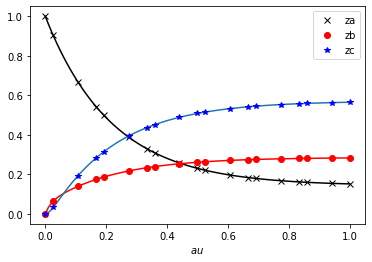

In [121]:
# Create Pyomo model
model = create_model()

# Initialize discretized model with simulation result?
init = True

# Number of finite elements
NFE = 6

# Simulate model
sim, tsim, profiles = simulate_discretize_model(model,NFE,init)

# Plot simulation results
plot_result(model, sim, tsim, profiles,True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

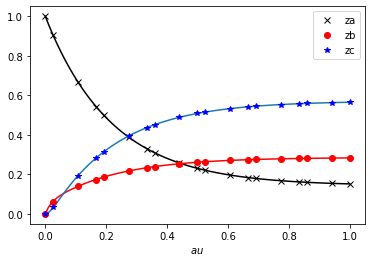

In [122]:
# Solve collocation formulation with Ipopt
solve_model(model)

# Plot results
plot_result(model, sim, tsim, profiles, True)

### Simulate and solve Pyomo model without initialization

Repeat the analysis from above, but do NOT initialize the discretized model with the simulation result. (Tip: you only need to change two small things.)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

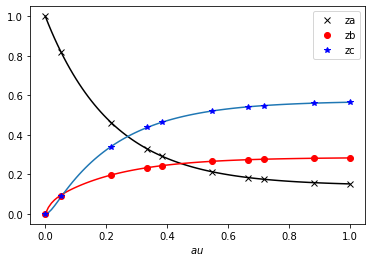

In [123]:
# Add your solution here
# Create Pyomo model
model = create_model()

# Initialize discretized model with simulation result?
init = False

# Number of finite elements
NFE = 3

# Simulate model
sim, tsim, profiles = simulate_discretize_model(model,NFE,init)

# Solve collocation formulation with Ipopt
solve_model(model)

# Plot simulation results
plot_result(model, sim, tsim, profiles,True)

### Discussion: Does initialization matter?

Write 1 to 3 sentences for each of the following questions:

1) What happens if we disable initialization? 

**Answer:**

By disabling the initialization no special changes happened and both problems results in the same answer.


2) Does the number of interactions Ipopt need change?

**Answer:**

No, the number of iterations are exactly the same!

3) Why is this specific problem robust to poor initialization? What about this specific DAE system makes it easy to solve?

**Answer:**

This problem first of all is an index one problem. Secondly, the dimension of the problem is not high. So, this specific problem is robust to poor initialization.

### Degree of Freedom Analysis

Please answer on paper and turn in via Gradescope.

**The answer to all following questions are provided in the GradeScope**

Rerun the code above for two different numbers of finite elements. Record the total number of variables and equality constraints.

How many degrees of freedom are in the simulation problem? (1 sentence is fine.)

Choose $N=3$ or a similar number of finite elements. Using the collocation equations from class, show that the discretized Pyomo model has the correct number of variables and algebriac equations. This will be a little tedious, but good to practice once on a simple model. You might need to do this when debugging a DAE model for research.

Note: You might get a strange answer. That is okay.